# 전역변수 설정

In [1]:
# 입력 데이터 파일명
data_file = '양파.csv'

# 모델 출력 관측 시점
timespots = [30, 90, 180, 270, 365]

# LSTM, GRU, MLP 모델의 학습 반복횟수
epoch_num = 200
drop_out = 0.2
batch_size = 50
split = 0   # 이 값을 0으로 설정할 경우, validation 수행하지 않음

# 라이브러리 로드

In [2]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor as lgb
import lightgbm as lgb
# Classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

In [3]:
### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

In [4]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

# tf로드

In [5]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import Bidirectional, LSTM, RepeatVector, TimeDistributed # for creating layers inside the Neural Network
from keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime, timedelta, timezone
import keras
from datetime import datetime, timedelta, timezone
from keras.optimizers import SGD

# 데이터 로드

In [6]:
raw = pd.read_csv(data_file)
raw.drop(['Unnamed: 0'],axis=1,inplace=True)
raw = raw.iloc[:,:2]

raw.columns = ['datetime','price']
raw.set_index('datetime',inplace=True)

# Train,Test split

train_raw=raw[raw.index <= '2021-12-31']

for day_num in [30, 90, 180, 270, 365]:
    train_raw[f'price_{day_num}after'] = train_raw['price'].shift(-day_num)

# GRU - Multi Output

In [7]:
def lstm_data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix > x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix-1:end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [10]:
with tf.device("/device:CPU:0"):
    
    train_raw_new = train_raw.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

    ## Parameters
    scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
    X_train_raw_new = scaler_X_tr.fit_transform(train_raw_new)

    X_train_raw_new = pd.DataFrame(X_train_raw_new) 
    
    y_train_raw_new = X_train_raw_new.iloc[:, -5:]
    x_train_raw_new = X_train_raw_new.iloc[:, :-5]
    
    (X_train_raw, Y_train_raw) = lstm_data_transform(x_train_raw_new, y_train_raw_new, 365)
    
    if split == 0:
        x_train = X_train_raw
        y_train = Y_train_raw
    else:
        x_train = X_train_raw[:-split]
        y_train = Y_train_raw[:-split]
        x_valid = X_train_raw[-split:]
        y_valid = Y_train_raw[-split:]

        X_valid = x_train.reshape(-1, 365, 1)
        Y_valid = y_train.reshape(-1, 1, 5)

        
    X_train = x_train.reshape(-1, 365, 1)
    Y_train = y_train.reshape(-1, 1, 5)

    model = Sequential()

    model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    model.add(GRU(units = 50, 
                         activation = 'tanh'))
    model.add(Dropout(drop_out))
    model.add(Dense(units=5))
    
    model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                          momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    model.summary()

    es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

    if split == 0:
        model_fit = model.fit(X_train, Y_train, epochs=epoch_num, batch_size=batch_size, verbose=2)
    else:
        model_fit = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epoch_num, batch_size=batch_size, callbacks=es, verbose=2)
    
    # save model   
    model.save("gru_multiout")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 365, 50)           7950      
                                                                 
 gru_5 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 23,505
Trainable params: 23,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
43/43 - 12s - loss: 0.0656 - 12s/epoch - 290ms/step
Epoch 2/200
43/43 - 8s - loss: 0.0371 - 8s/epoch - 194ms/step
Epoch 3/200
43/43 - 8s - loss: 0.0359 - 8s/epoch - 194ms

Epoch 116/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 190ms/step
Epoch 117/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 185ms/step
Epoch 118/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 191ms/step
Epoch 119/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 189ms/step
Epoch 120/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 183ms/step
Epoch 121/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 184ms/step
Epoch 122/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 184ms/step
Epoch 123/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 183ms/step
Epoch 124/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 182ms/step
Epoch 125/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 185ms/step
Epoch 126/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 188ms/step
Epoch 127/200
43/43 - 9s - loss: 0.0333 - 9s/epoch - 207ms/step
Epoch 128/200
43/43 - 8s - loss: 0.0333 - 8s/epoch - 196ms/step
Epoch 129/200
43/43 - 8s - loss: 0.0333 - 8s/epoch - 191ms/step
Epoch 130/200
43/43 - 8s - loss: 0.0332 - 8s/epoch - 188ms/step
Epoch 131/200
43/43 - 8s - loss: 0.0332 

INFO:tensorflow:Assets written to: gru_multiout\assets


INFO:tensorflow:Assets written to: gru_multiout\assets


In [27]:
pred = []
ptr = 0

load_model = keras.models.load_model("gru_multiout")

for day_num in timespots:

    y_test_pre = []
    x_test = train_raw.iloc[-729-day_num:-day_num, :]
    
    X_tr = scaler_X_tr.transform(x_test)
    X_tr = pd.DataFrame(X_tr) 
    
    X_tr = X_tr.iloc[:, :-5]
    
    X = list()
    num_steps = 365

    for i in range(x_test.shape[0]):
        end_ix = i + num_steps

        if end_ix > x_test.shape[0]:
            break

        seq_X = X_tr[i:end_ix]
        X.append(seq_X)

    # Make final arrays
    x_array = np.array(X)

    X_test = x_array.reshape(-1, 365, 1)
    y_test = load_model.predict(X_test)

    y_test = pd.DataFrame(y_test)
    y_test['new'] = y_test[0]
    
    y_test_pred = scaler_X_tr.inverse_transform(y_test)
    
    for j in range(0, 365):
        y_test_pre.append(y_test_pred[j][ptr])

    pred.append(y_test_pre)
    ptr = ptr + 1

12/12 [==============================] - 0s 9ms/step


Model30 Results



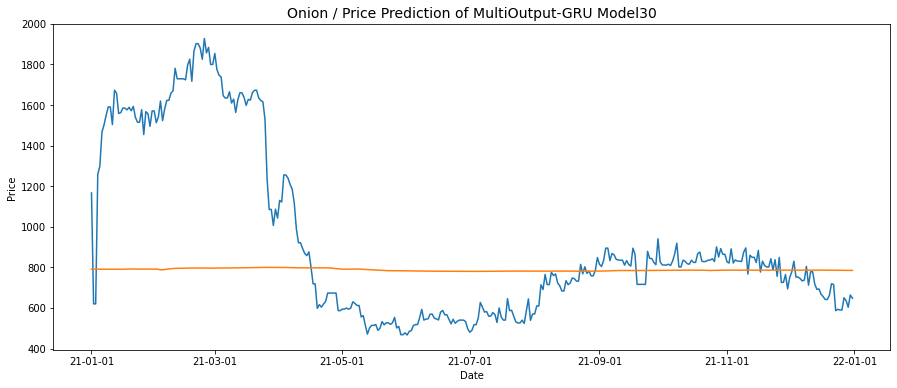

MAPE=0.28712827195936097
RMSE=432.89191055869765



Model90 Results



<Figure size 432x288 with 0 Axes>

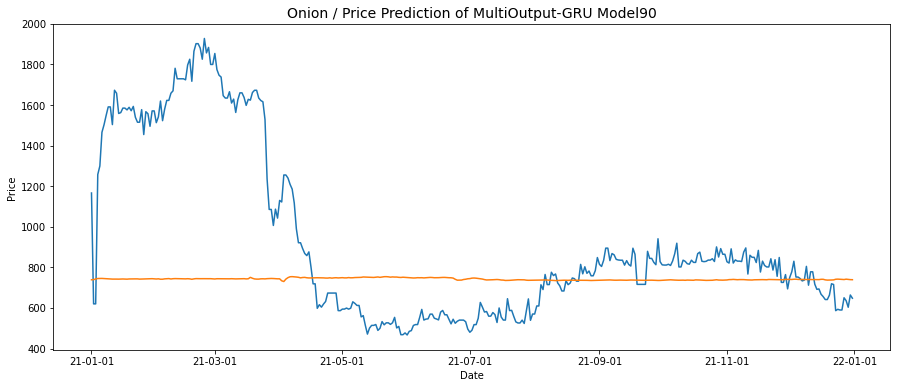

MAPE=0.2815642248773134
RMSE=453.17152695135695



Model180 Results



<Figure size 432x288 with 0 Axes>

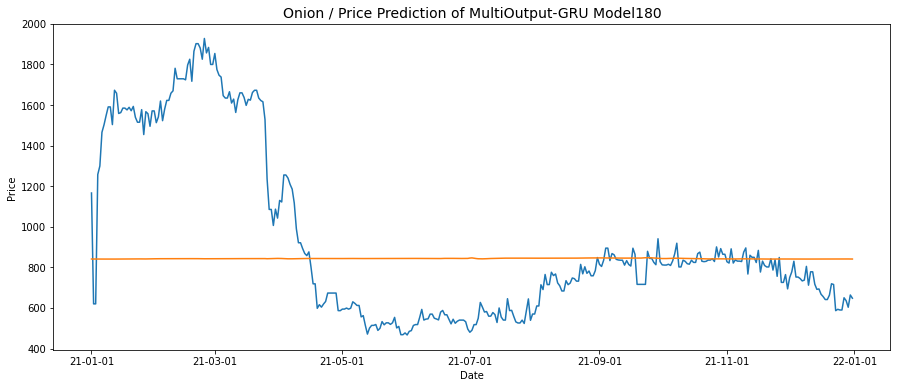

MAPE=0.31748157494695517
RMSE=423.3197103444597



Model270 Results



<Figure size 432x288 with 0 Axes>

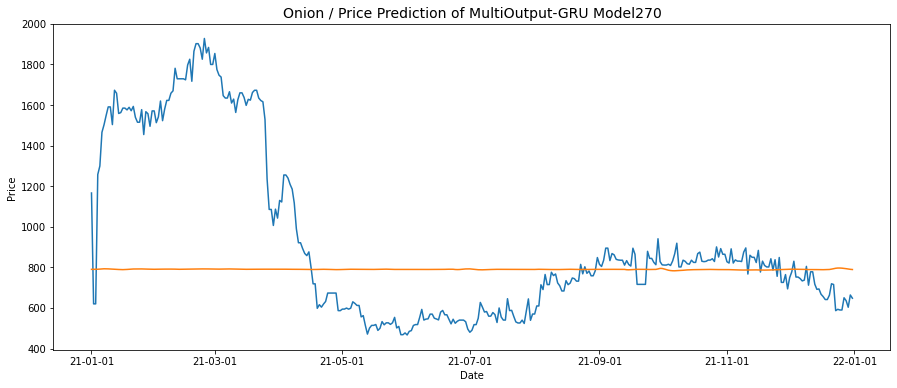

MAPE=0.2915001646645664
RMSE=435.6543773644106



Model365 Results



<Figure size 432x288 with 0 Axes>

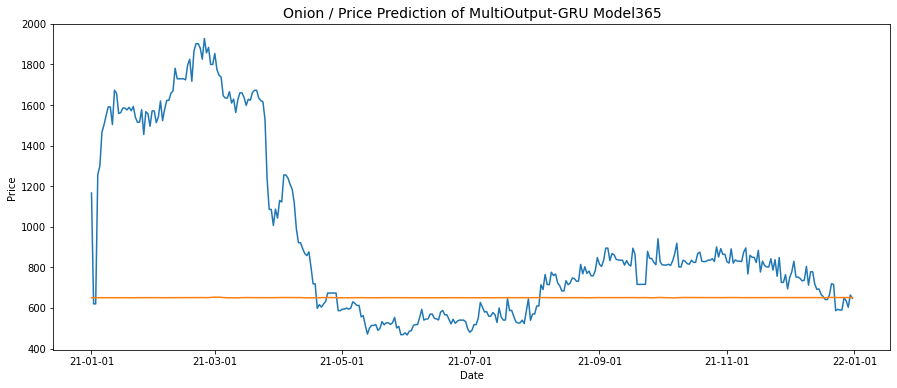

MAPE=0.28006991674081616
RMSE=497.03709708722437





<Figure size 432x288 with 0 Axes>

In [30]:
label = timespots

for i in range(0, len(timespots)):
    
    print(f'Model{label[i]} Results\n')
    
    test = train_raw[-365:]

    plot_data = pd.DataFrame([test['price'].values, pred[i]]).T
    date_label = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
    
    fig, ax = plt.subplots(figsize=(15,6))
        
    plot_data.columns = ['actual','pred']
    ax.plot(date_label, plot_data)
    
    plt.title('Onion / Price Prediction of MultiOutput-GRU Model' + str(label[i]), fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    
    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)
    
    plt.show()
    plt.clf()
    
    MAPE = mean_absolute_percentage_error(test['price'].values.flatten(), pred[i])
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(test['price'].values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')